In [160]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [161]:
class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        return torch.reshape(img, self.new_size)

In [162]:
mnist_transforms=[
            transforms.Grayscale(),
            transforms.ToTensor()]
mnist_transforms.append(ReshapeTransform((-1,)))

WW = 20
HH = 20

In [163]:
data_dir = 'D:/Data/MoldPID/pins-taf/top'

def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose(mnist_transforms)

    test_transforms = transforms.Compose(mnist_transforms)

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)
NC = len(trainloader.dataset.classes)


['0', '1']


In [164]:
NC = len(trainloader.dataset.classes)
NC

2

In [165]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet50(pretrained=True)
# model = torch.load('pinbottommodel.pth')
# model

In [166]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(WW * HH, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, NC) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
model = MNISTNet(100)
model

MNISTNet(
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (ac1): Sigmoid()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [167]:
# Freeze parameters so we don't backprop through them
# for param in model.parameters():
#     param.requires_grad = False
    
# model.fc = nn.Sequential(nn.Linear(2048, 512),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(512, 10),
#                                  nn.LogSoftmax(dim=1))
# criterion = nn.NLLLoss()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
model.to(device)

MNISTNet(
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (ac1): Sigmoid()
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [168]:
epochs = 37
steps = 0
running_loss = 0
print_every = 100
train_losses, test_losses = [], []
print(len(trainloader))

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print(steps)
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

torch.save(model, 'pintopmodel-taf-FC.pth')
torch.save(model.state_dict(), 'pintopmodel-taf-FC-S.pth')

983
100
Epoch 1/37.. Train loss: 0.134.. Test loss: 0.043.. Test accuracy: 0.988
200
Epoch 1/37.. Train loss: 0.045.. Test loss: 0.038.. Test accuracy: 0.989
300
Epoch 1/37.. Train loss: 0.029.. Test loss: 0.033.. Test accuracy: 0.990
400
Epoch 1/37.. Train loss: 0.028.. Test loss: 0.035.. Test accuracy: 0.989
500
Epoch 1/37.. Train loss: 0.028.. Test loss: 0.026.. Test accuracy: 0.991
600
Epoch 1/37.. Train loss: 0.026.. Test loss: 0.027.. Test accuracy: 0.991
700
Epoch 1/37.. Train loss: 0.024.. Test loss: 0.025.. Test accuracy: 0.991
800
Epoch 1/37.. Train loss: 0.027.. Test loss: 0.025.. Test accuracy: 0.991
900
Epoch 1/37.. Train loss: 0.024.. Test loss: 0.020.. Test accuracy: 0.993
1000
Epoch 2/37.. Train loss: 0.025.. Test loss: 0.022.. Test accuracy: 0.993
1100
Epoch 2/37.. Train loss: 0.022.. Test loss: 0.021.. Test accuracy: 0.992
1200
Epoch 2/37.. Train loss: 0.026.. Test loss: 0.019.. Test accuracy: 0.993
1300
Epoch 2/37.. Train loss: 0.029.. Test loss: 0.020.. Test accurac

10600
Epoch 11/37.. Train loss: 0.013.. Test loss: 0.013.. Test accuracy: 0.995
10700
Epoch 11/37.. Train loss: 0.014.. Test loss: 0.014.. Test accuracy: 0.995
10800
Epoch 11/37.. Train loss: 0.013.. Test loss: 0.013.. Test accuracy: 0.995
10900
Epoch 12/37.. Train loss: 0.015.. Test loss: 0.012.. Test accuracy: 0.996
11000
Epoch 12/37.. Train loss: 0.011.. Test loss: 0.019.. Test accuracy: 0.993
11100
Epoch 12/37.. Train loss: 0.016.. Test loss: 0.045.. Test accuracy: 0.984
11200
Epoch 12/37.. Train loss: 0.015.. Test loss: 0.015.. Test accuracy: 0.994
11300
Epoch 12/37.. Train loss: 0.014.. Test loss: 0.013.. Test accuracy: 0.995
11400
Epoch 12/37.. Train loss: 0.013.. Test loss: 0.011.. Test accuracy: 0.996
11500
Epoch 12/37.. Train loss: 0.015.. Test loss: 0.013.. Test accuracy: 0.995
11600
Epoch 12/37.. Train loss: 0.011.. Test loss: 0.012.. Test accuracy: 0.996
11700
Epoch 12/37.. Train loss: 0.015.. Test loss: 0.012.. Test accuracy: 0.996
11800
Epoch 13/37.. Train loss: 0.018.. 

20900
Epoch 22/37.. Train loss: 0.013.. Test loss: 0.012.. Test accuracy: 0.996
21000
Epoch 22/37.. Train loss: 0.014.. Test loss: 0.011.. Test accuracy: 0.995
21100
Epoch 22/37.. Train loss: 0.011.. Test loss: 0.013.. Test accuracy: 0.996
21200
Epoch 22/37.. Train loss: 0.013.. Test loss: 0.011.. Test accuracy: 0.996
21300
Epoch 22/37.. Train loss: 0.011.. Test loss: 0.011.. Test accuracy: 0.995
21400
Epoch 22/37.. Train loss: 0.010.. Test loss: 0.014.. Test accuracy: 0.994
21500
Epoch 22/37.. Train loss: 0.014.. Test loss: 0.013.. Test accuracy: 0.995
21600
Epoch 22/37.. Train loss: 0.015.. Test loss: 0.016.. Test accuracy: 0.994
21700
Epoch 23/37.. Train loss: 0.021.. Test loss: 0.014.. Test accuracy: 0.994
21800
Epoch 23/37.. Train loss: 0.011.. Test loss: 0.016.. Test accuracy: 0.995
21900
Epoch 23/37.. Train loss: 0.014.. Test loss: 0.015.. Test accuracy: 0.994
22000
Epoch 23/37.. Train loss: 0.010.. Test loss: 0.012.. Test accuracy: 0.996
22100
Epoch 23/37.. Train loss: 0.008.. 

31200
Epoch 32/37.. Train loss: 0.013.. Test loss: 0.013.. Test accuracy: 0.995
31300
Epoch 32/37.. Train loss: 0.014.. Test loss: 0.015.. Test accuracy: 0.994
31400
Epoch 32/37.. Train loss: 0.011.. Test loss: 0.014.. Test accuracy: 0.995
31500
Epoch 33/37.. Train loss: 0.017.. Test loss: 0.011.. Test accuracy: 0.996
31600
Epoch 33/37.. Train loss: 0.008.. Test loss: 0.012.. Test accuracy: 0.995
31700
Epoch 33/37.. Train loss: 0.013.. Test loss: 0.013.. Test accuracy: 0.995
31800
Epoch 33/37.. Train loss: 0.013.. Test loss: 0.012.. Test accuracy: 0.996
31900
Epoch 33/37.. Train loss: 0.013.. Test loss: 0.012.. Test accuracy: 0.996
32000
Epoch 33/37.. Train loss: 0.013.. Test loss: 0.011.. Test accuracy: 0.996
32100
Epoch 33/37.. Train loss: 0.013.. Test loss: 0.012.. Test accuracy: 0.996
32200
Epoch 33/37.. Train loss: 0.009.. Test loss: 0.012.. Test accuracy: 0.995
32300
Epoch 33/37.. Train loss: 0.012.. Test loss: 0.014.. Test accuracy: 0.995
32400
Epoch 33/37.. Train loss: 0.014.. 

C:\Users\dustinin\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MNISTNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


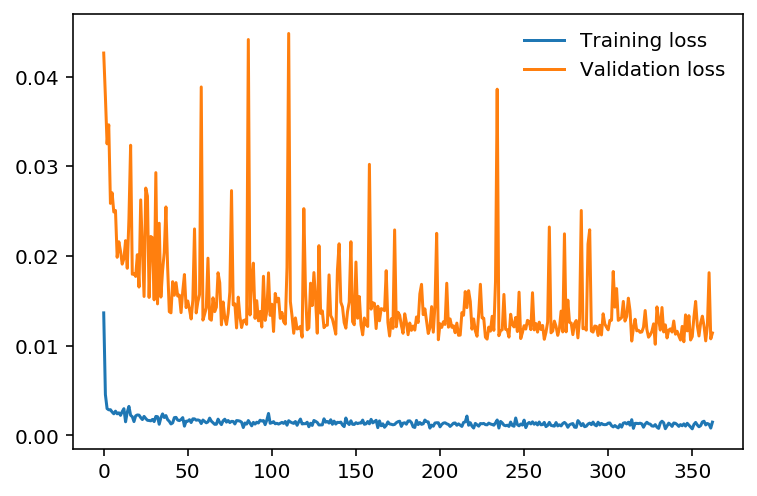

In [169]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()